# Modelos: KNN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
DATASET_PATH = f'{BASE_PATH}/datasets'
WEIGHTS_PATH = f'{BASE_PATH}/weights'
METRICS_PATH = f'{BASE_PATH}/metrics/knn'

In [3]:
import sys
# sys.path.append(f'/home/adrian/development/personal/pytorch_common')
sys.path.append(LIB_PATH)

import numpy as np
import pandas as pd

import torch
import pytorch_common.util as pu

import model as ml
import data.dataset as ds

import metric as mt
import metric.discretizer as dr

import data.plot as pl
import util as ut

import random

import util as ut

2023-04-07 09:08:43.462324: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/adrian/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/adrian/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


## Setup

In [4]:
import pytorch_common
pytorch_common.__version__

'0.1.0'

In [5]:
torch.__version__

'1.11.0'

In [6]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [7]:
pu.set_device_name('gpu')
cpu = torch.device("cpu")

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

In [9]:
TRAIN = False

## Carga de dataset

In [10]:
def to_tensor(obs, device, columns): 
    data = obs[columns]
    if type(data) == pd.DataFrame:
        data = data.values
    return torch.tensor(data).to(device)

features_fn = lambda obs, device: to_tensor(obs, device, ['user_seq', 'movie_seq'])
target_fn   = lambda obs, device: to_tensor(obs, device, ['user_movie_rating'])

dataset = ds.MovieLensTMDBDatasetFactory.from_path(
    path             = DATASET_PATH,
    transform        = features_fn,
    target_transform = target_fn,
    device           = cpu,
    filter_fn        = lambda df: df[(df['user_movie_rating_year'] >= 2005) & (df['user_movie_rating_year'] <= 2019)]
)
dataset.info

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153892 entries, 0 to 153891
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   user_id                      153892 non-null  int64         
 1   user_seq                     153892 non-null  int64         
 2   user_movie_tags              153892 non-null  object        
 3   user_movie_rating            153892 non-null  int64         
 4   user_movie_rating_timestamp  153892 non-null  datetime64[ns]
 5   user_movie_rating_year       153892 non-null  int64         
 6   movie_id                     153892 non-null  int64         
 7   movie_seq                    153892 non-null  int64         
 8   movie_title                  153892 non-null  string        
 9   movie_genres                 153892 non-null  object        
 10  movie_for_adults             153892 non-null  bool          
 11  movie_original_language   

In [11]:
train_set, eval_set = dataset.split_train_eval(split_year=2018)

2023-04-07 09:08:46,288 - INFO - Train: 82.85 % - Test: 8.97 %


## Entrenamiento del modelo

In [12]:
if TRAIN:
    user_predictor = ml.KNNUserBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [13]:
if TRAIN:
    user_predictor.plot()

In [14]:
if TRAIN:
    item_predictor = ml.KNNItemBasedPredictor.from_data_frame(
        data          = train_set.data,
        user_seq_col  = 'user_seq',
        movie_seq_col = 'movie_seq',
        rating_col    = 'user_movie_rating',
        distance      = ml.CosineDistance()
    )

In [15]:
if TRAIN:
    item_predictor.plot()

Se guardan los modelo entrenado:

In [16]:
if TRAIN:
    user_predictor.save(WEIGHTS_PATH, 'knn-user-predictor')
    item_predictor.save(WEIGHTS_PATH, 'knn-item-predictor')

In [17]:
if TRAIN:
    user_predictor.delete()
    item_predictor.delete()

## Validación del modelo

In [18]:
ut.free_gpu_memory()

In [19]:
user_predictor = ml.KNNUserBasedPredictor.from_file(WEIGHTS_PATH, 'knn-user-predictor')

In [20]:
item_predictor = ml.KNNItemBasedPredictor.from_file(WEIGHTS_PATH, 'knn-item-predictor')

Decoramos los predictores con un cache, para disminuir los tiempo de predicción, ya que no tiene sentido realizar dos veces la misma predicción para estos modelos, donde el resultado no es aleatorio:

In [21]:
cached_user_predictor = ml.CachedPredictor(user_predictor)
cached_item_predictor = ml.CachedPredictor(item_predictor)

Armamos un ensample para validar si mejora la performance de ambos modelos:

In [22]:
ensemple_predictor = ml.EnsemplePredictor([cached_user_predictor, cached_item_predictor])

In [23]:
def validation(
    predictors, 
    n_classes,
    n_samples    = 100, 
    batch_size   = 1000, 
    n_neighbors  = 100,
    k            = [5, 5],
    user_index   = 0,
    discretizers = [dr.between(4, 5), dr.between(3, 5)],
    summary_path = METRICS_PATH
):
    metrics    = [mt.RMSE()]

    for k, discretizer in zip(k, discretizers):
        metrics.extend([
            mt.MeanAveragePrecisionAtk(user_index=user_index, k=k, discretizer=discretizer),
            mt.MeanUserFBetaScoreAtk  (user_index=user_index, k=k, n_classes=n_classes, discretizer=discretizer),
            mt.MeanUserPrecisionAtk   (user_index=user_index, k=k, n_classes=n_classes, discretizer=discretizer),
            mt.MeanUserRecallAtk      (user_index=user_index, k=k, n_classes=n_classes, discretizer=discretizer)
        ])

    validator = ml.Validator(
        n_samples,
        batch_size,
        metrics,
        predictors
    )
    summary = validator.validate(eval_set, n_neighbors=n_neighbors)
    summary.save(summary_path)

In [31]:
validation(
    [cached_user_predictor, cached_item_predictor, ensemple_predictor],
    n_samples    = 200,
    batch_size   = 1000,
    n_neighbors  = 1000,
    summary_path = METRICS_PATH,
    n_classes    = len(dataset.target_uniques)
)

Processing:   0%|          | 0/200 [00:00<?, ?it/s]

In [32]:
summary = ml.ValidatorSummary.load(METRICS_PATH)
summary.show()

,sample,RMSE,"mAP@5(4,5)","MeanUserF1.0Score@5(4,5)","Precision@5(4,5)","Recall@5(4,5)","mAP@5(3,5)","MeanUserF1.0Score@5(3,5)","Precision@5(3,5)","Recall@5(3,5)"
predictor,,,,,,,,,,
KNNUserBasedPredictor,99.5,1.303017,0.376834,0.629055,0.630061,0.628034,0.457865,0.736294,0.737405,0.735954
"Ensemple[KNNUserBasedPredictor, KNNItemBasedPredictor]",99.5,1.362099,0.370989,0.671299,0.672483,0.672225,0.455490,0.677500,0.678495,0.676034
KNNItemBasedPredictor,99.5,1.760247,0.355061,0.635132,0.636172,0.636056,0.453209,0.687513,0.686169,0.686557


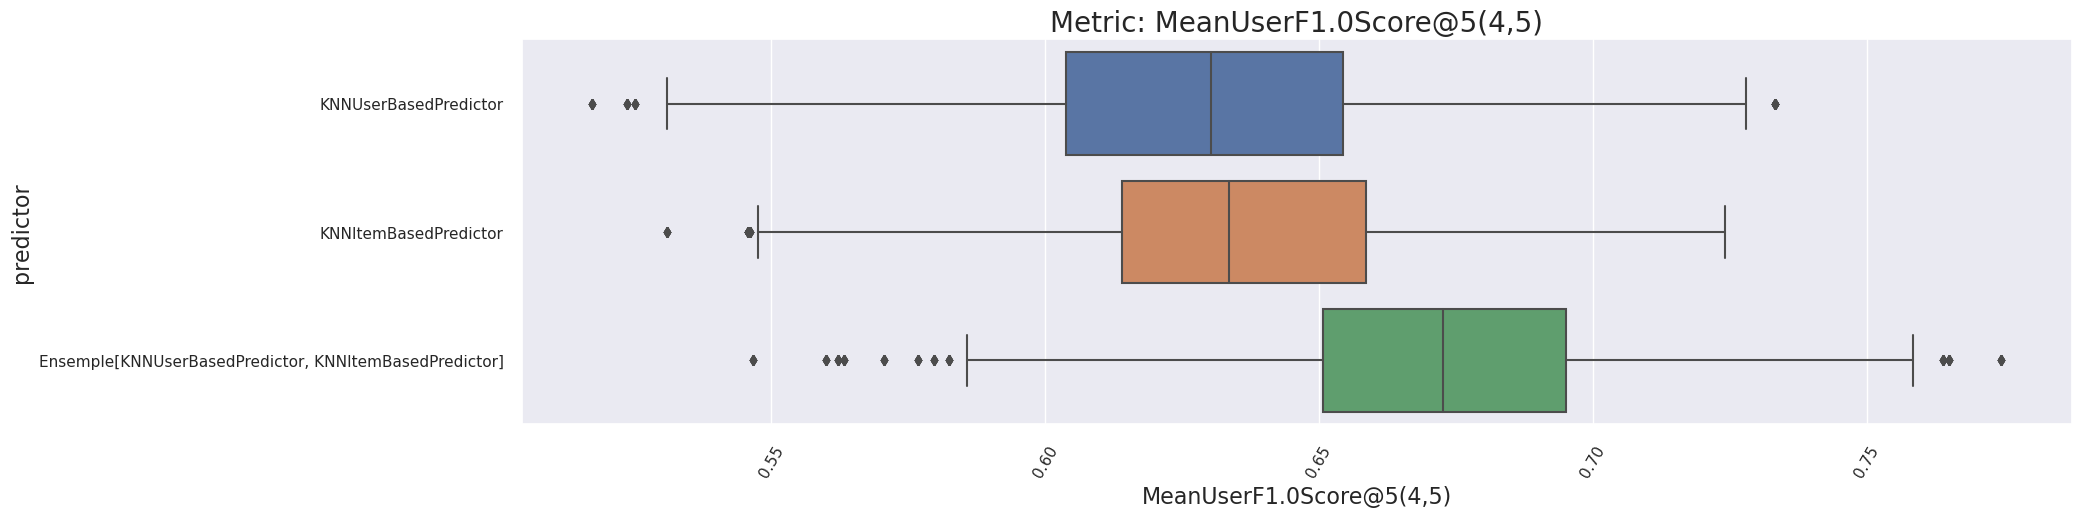

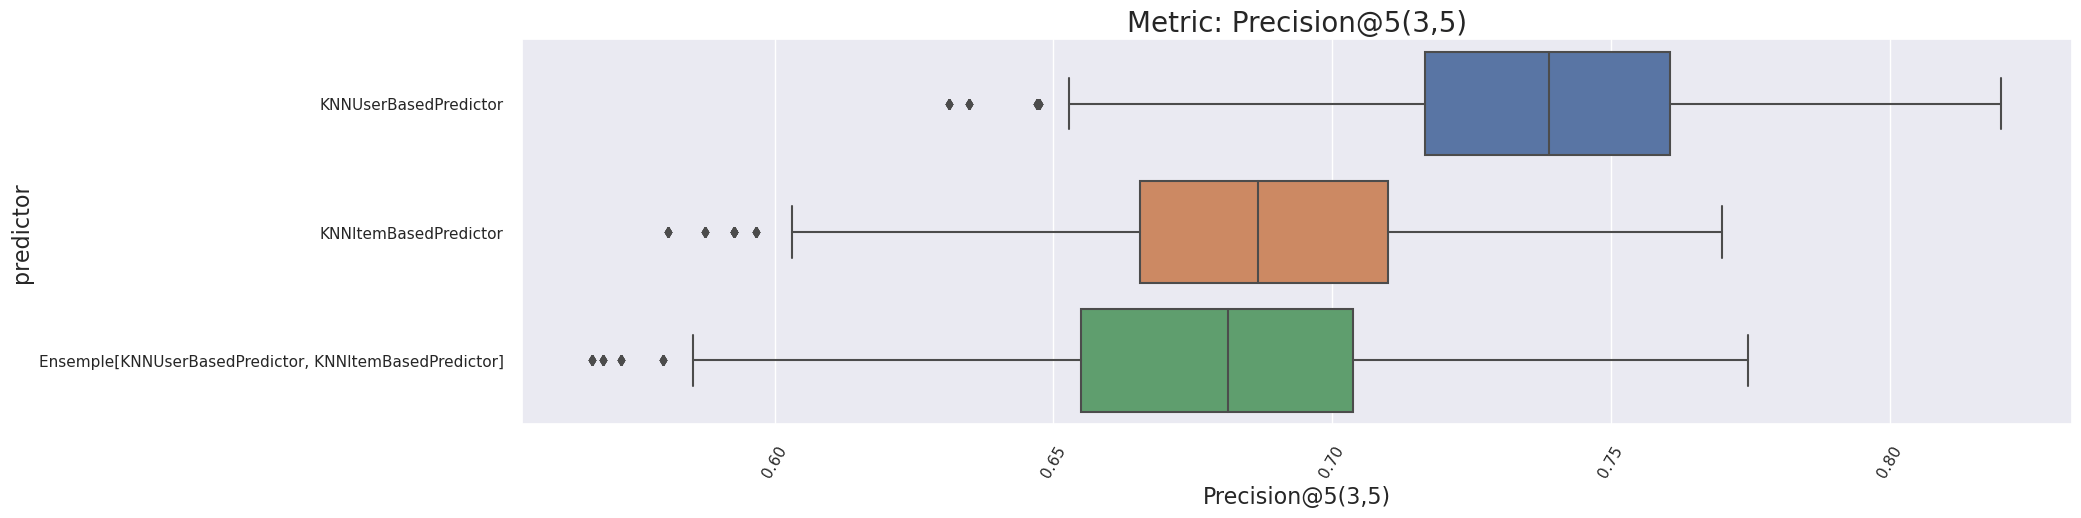

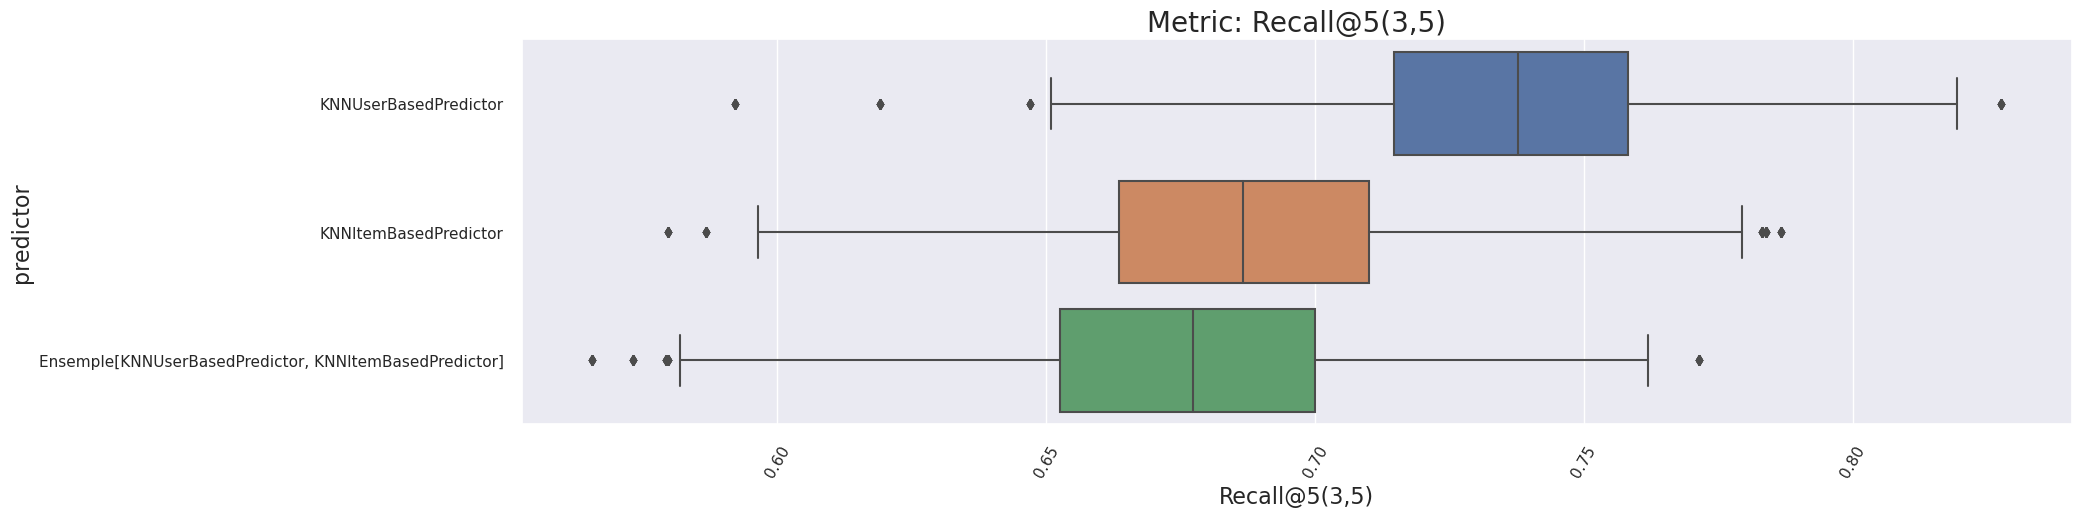

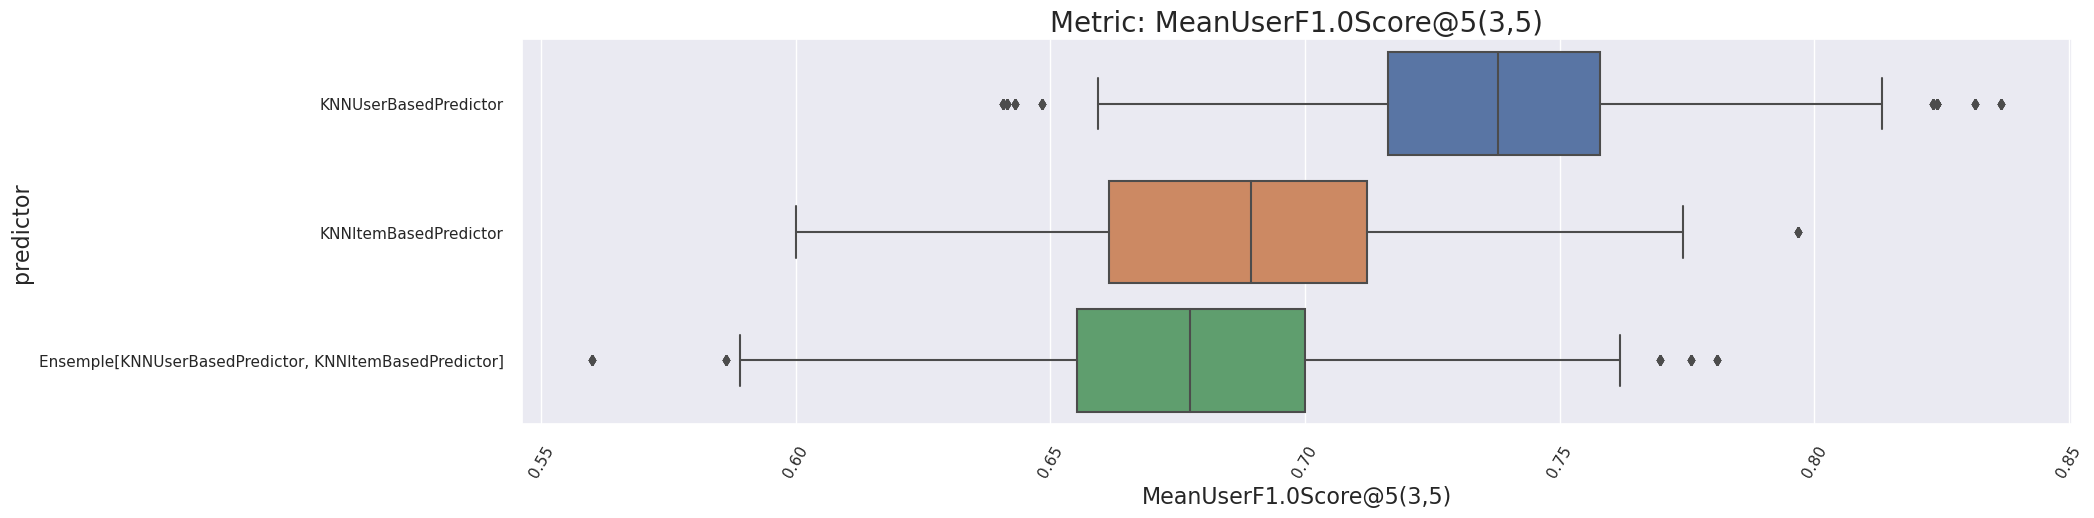

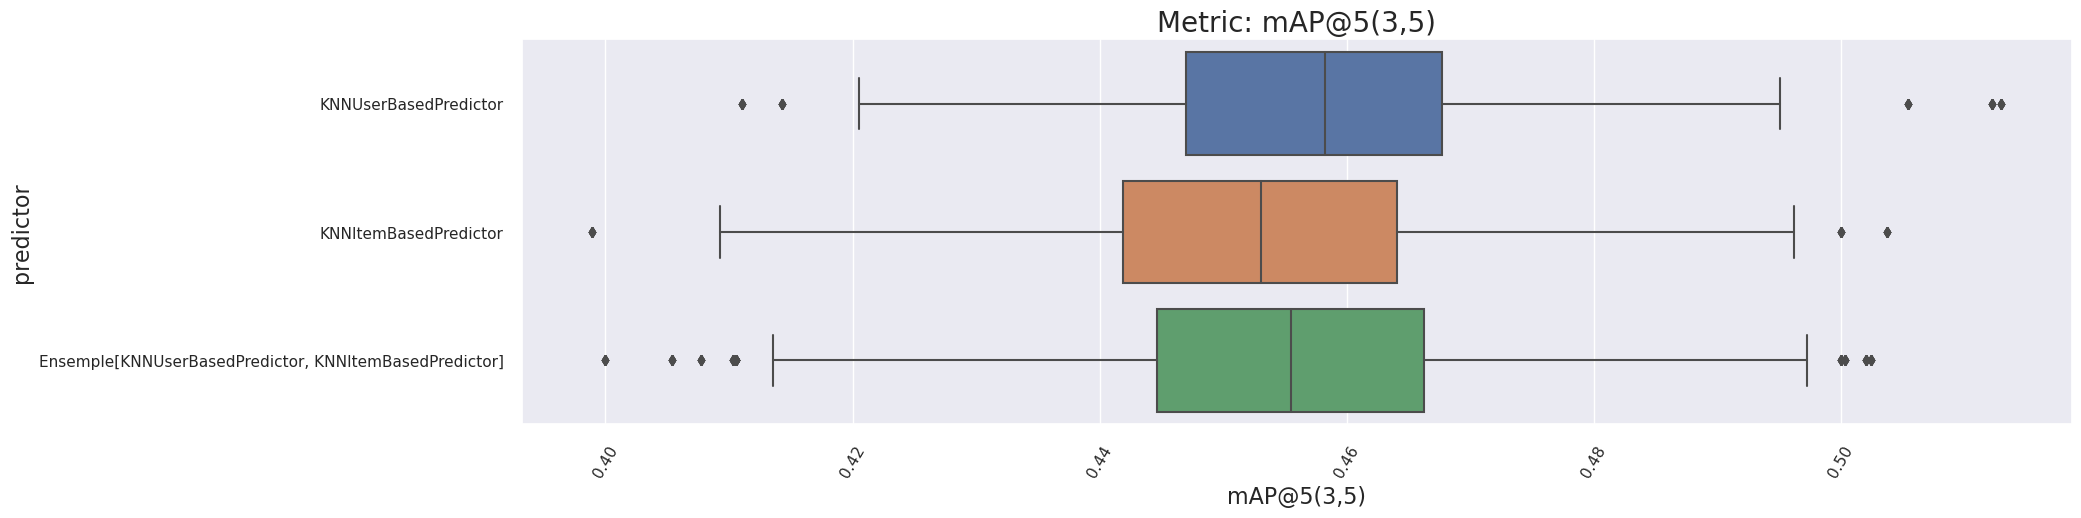

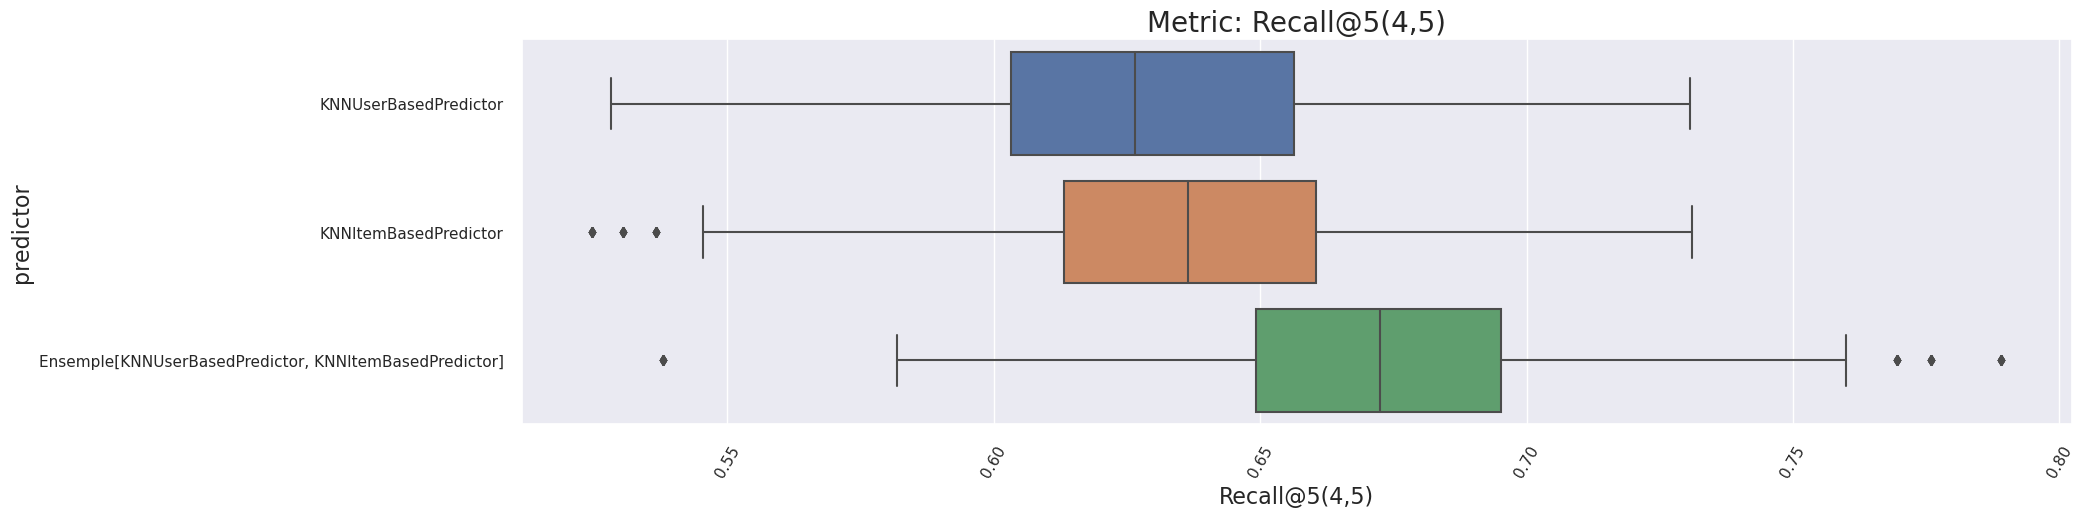

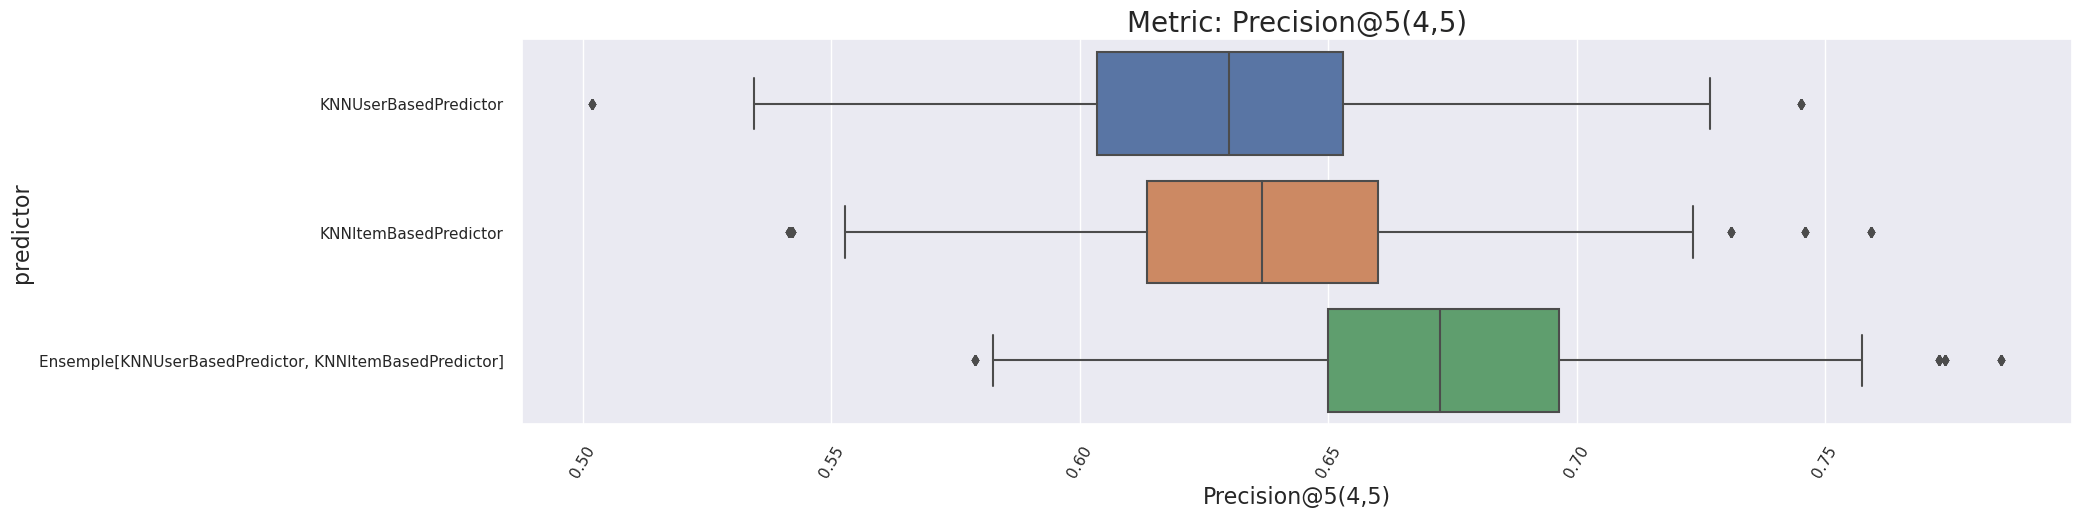

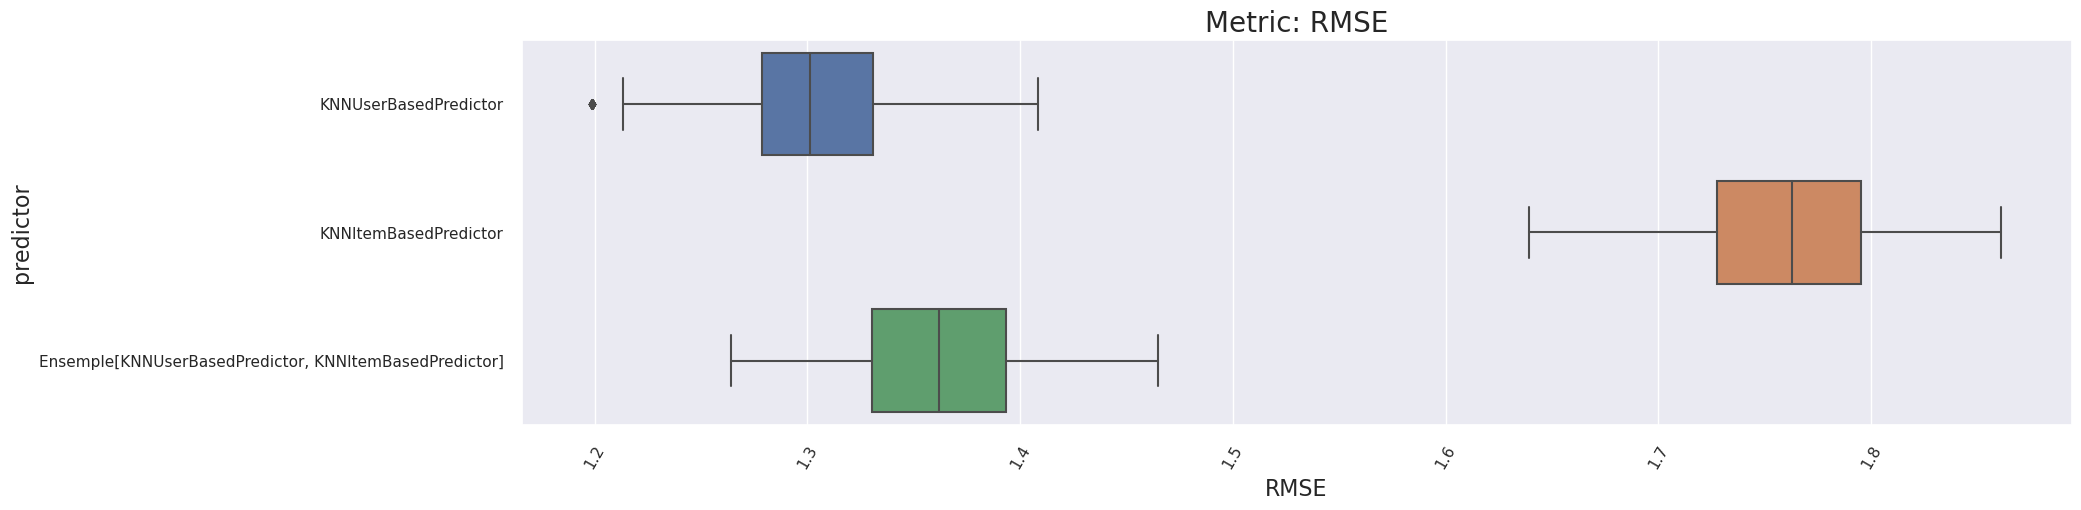

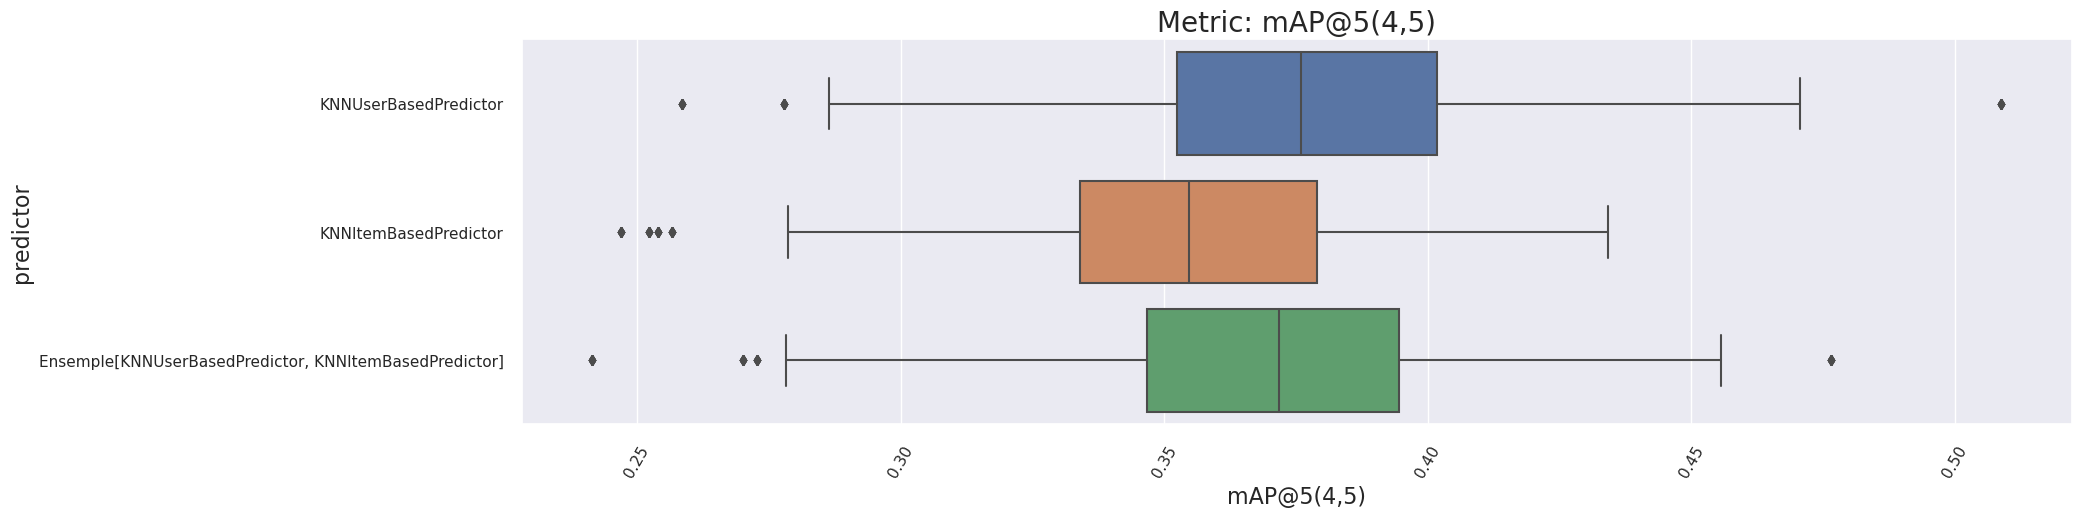

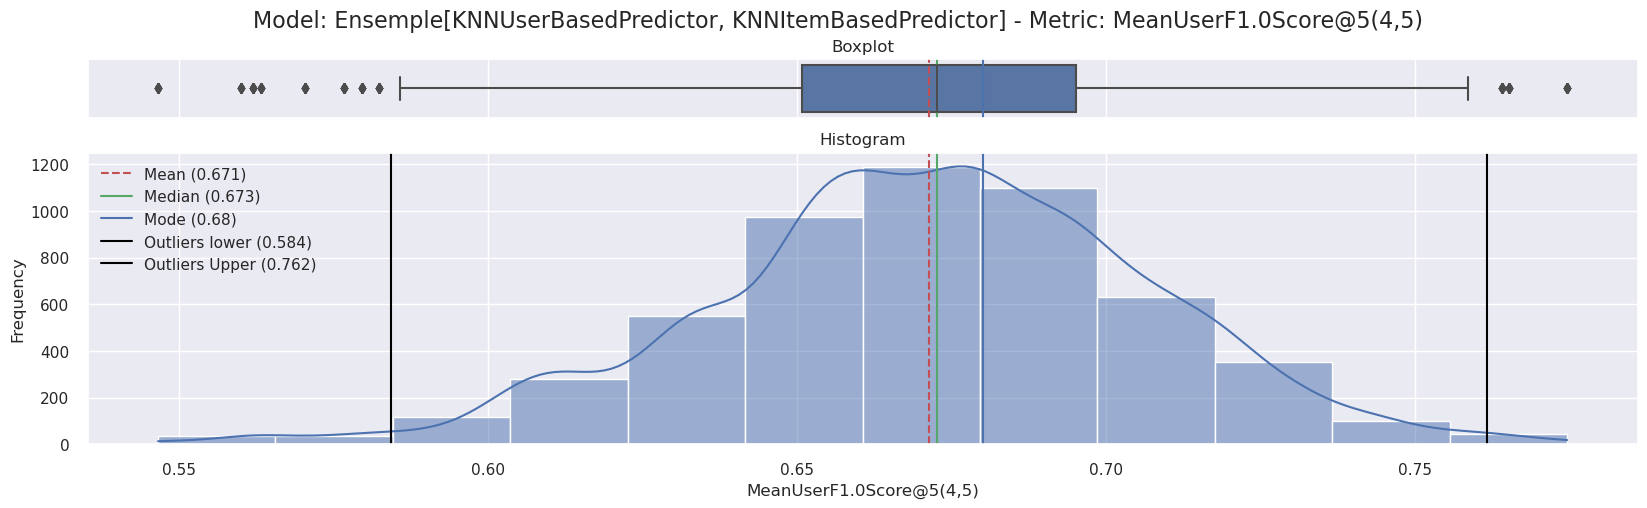

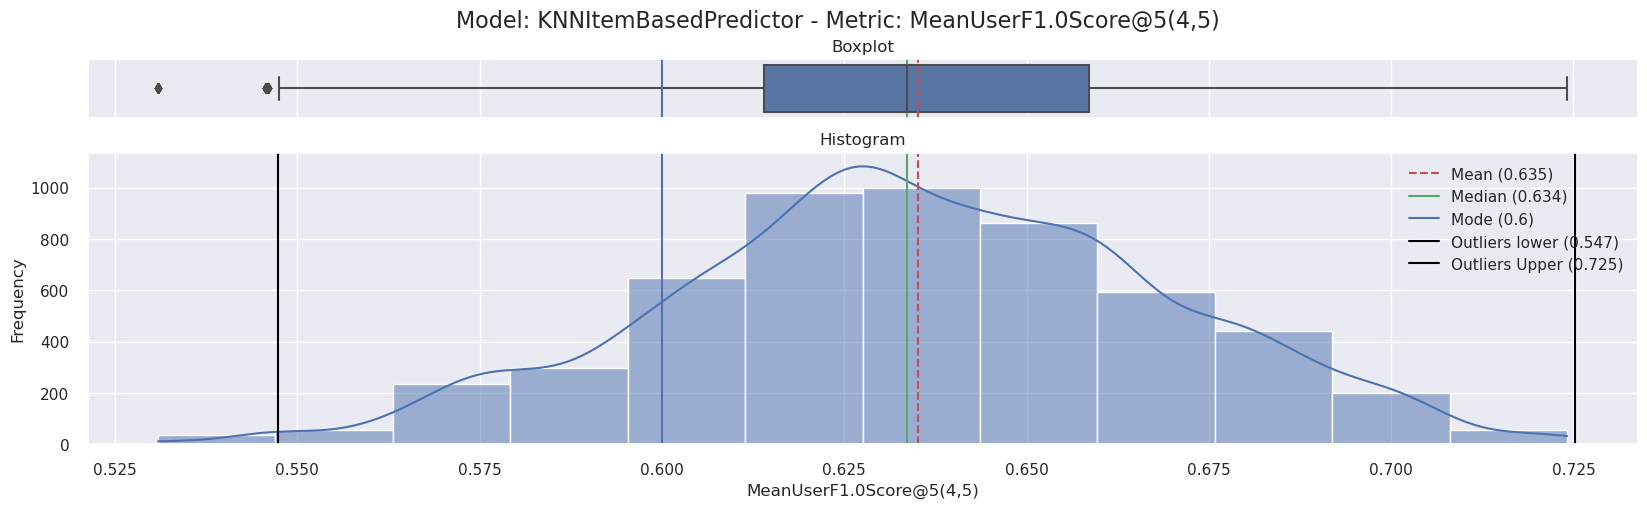

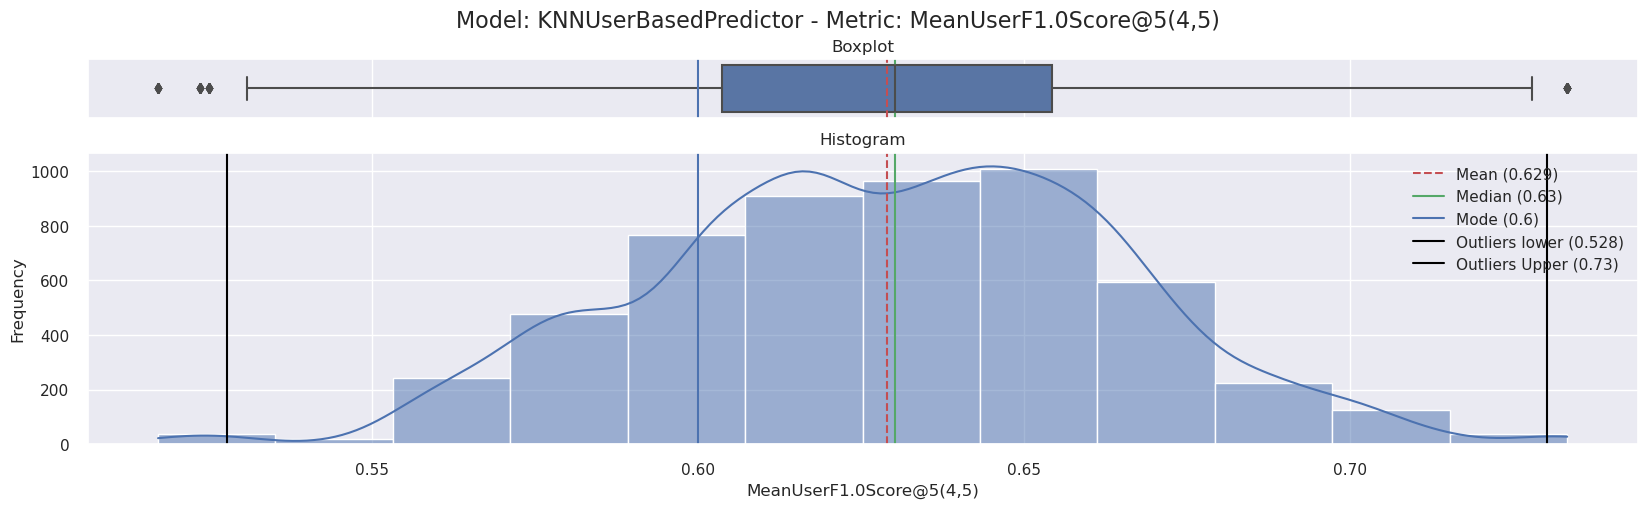

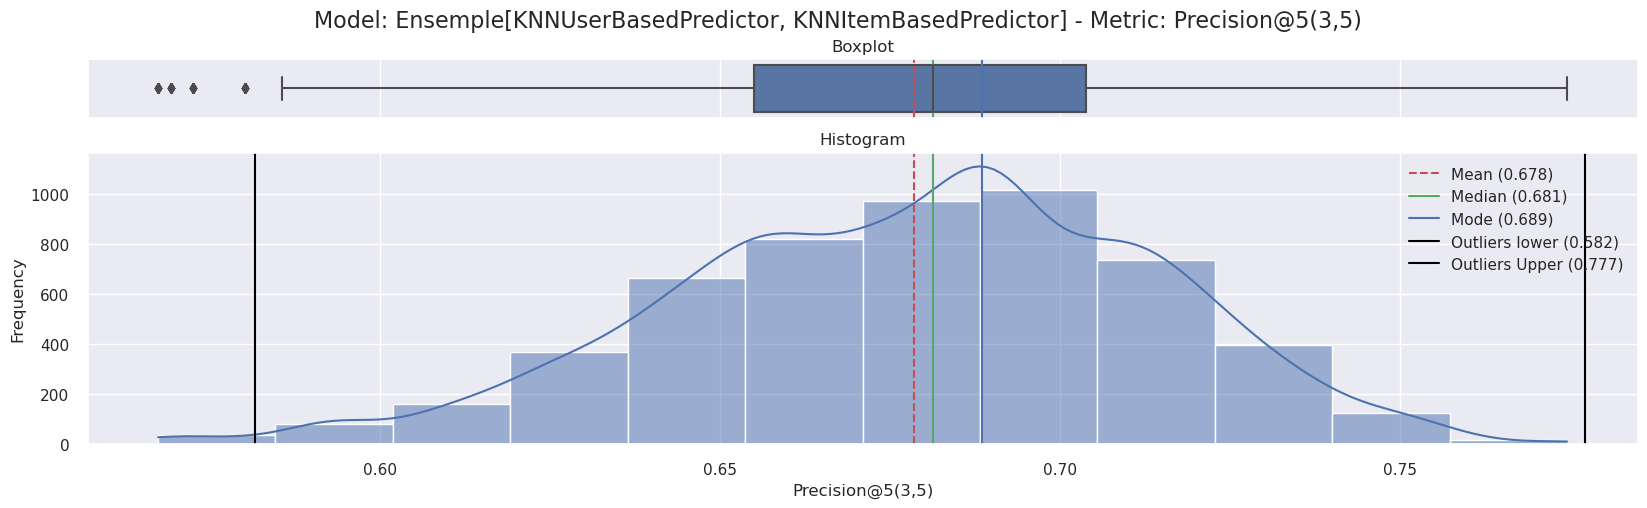

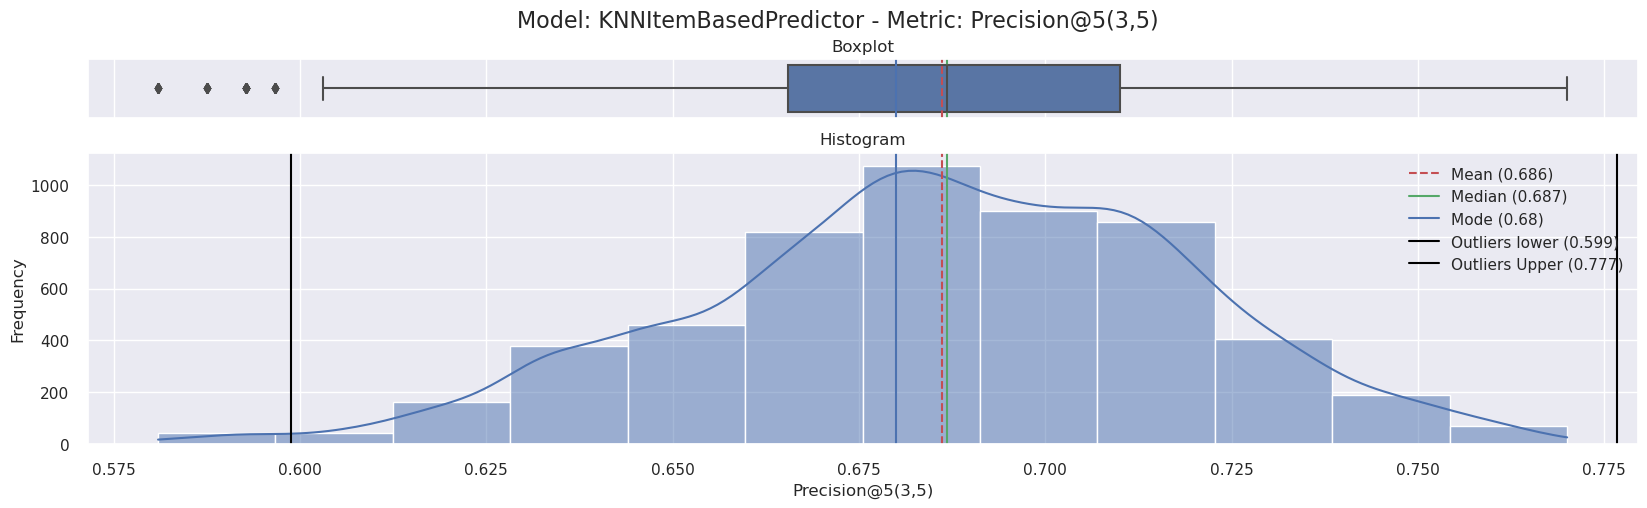

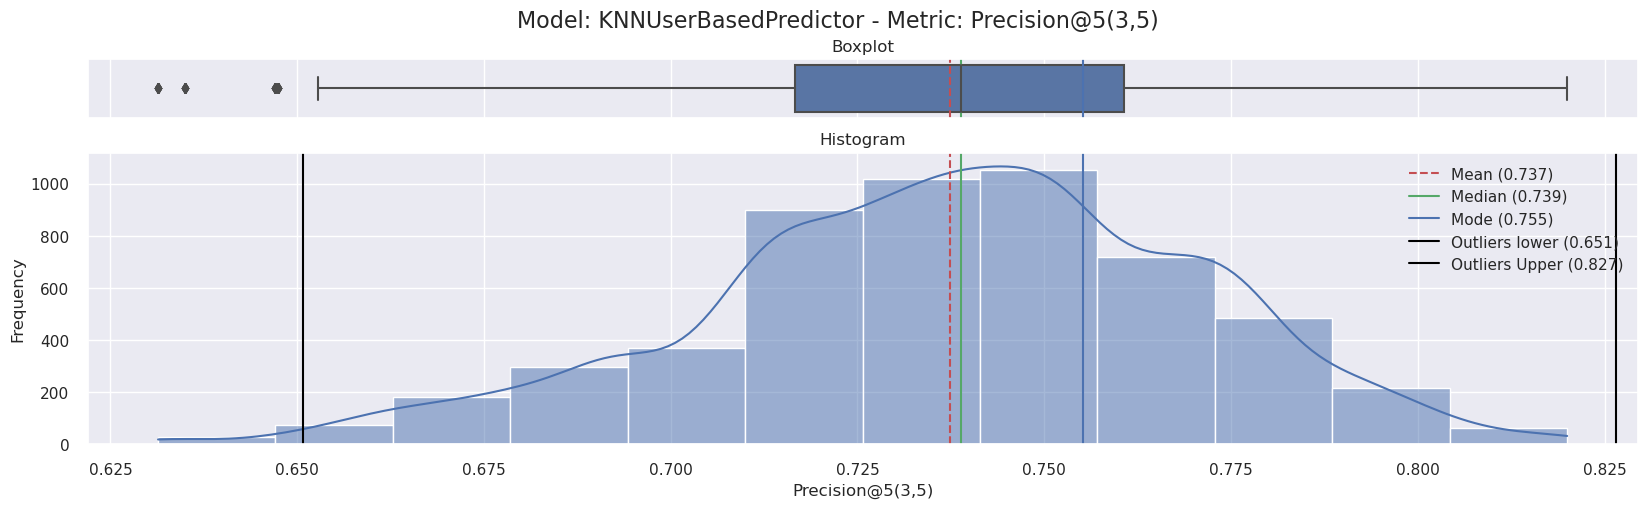

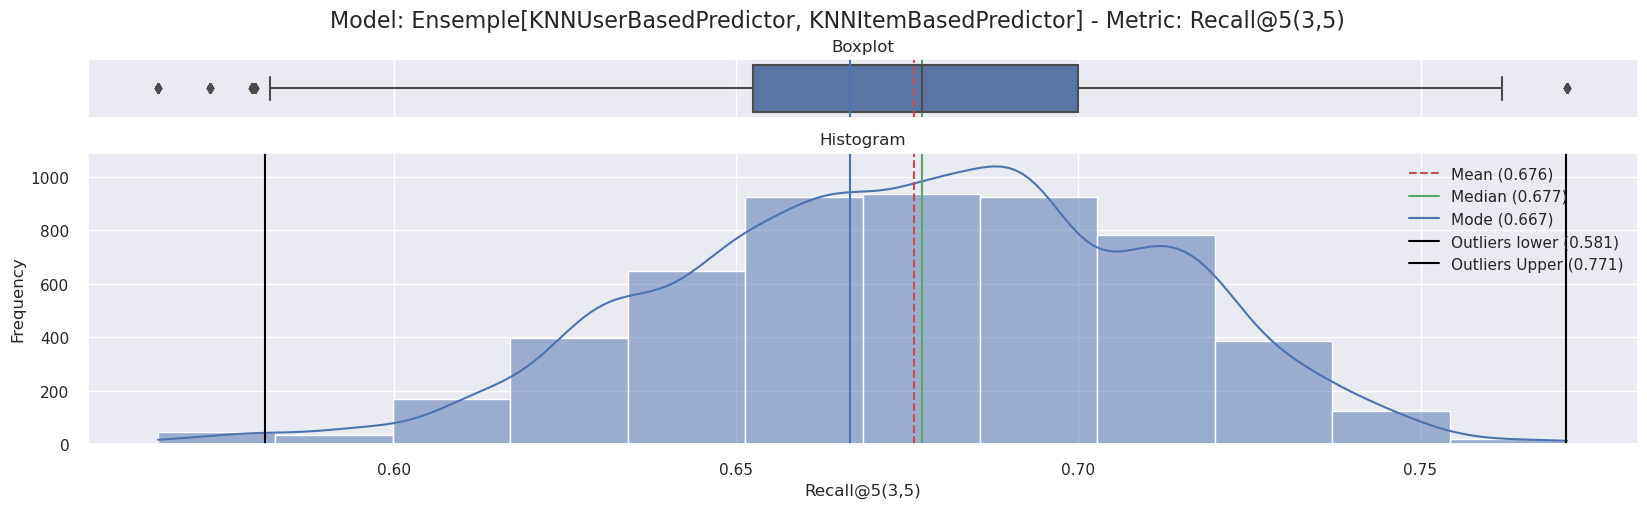

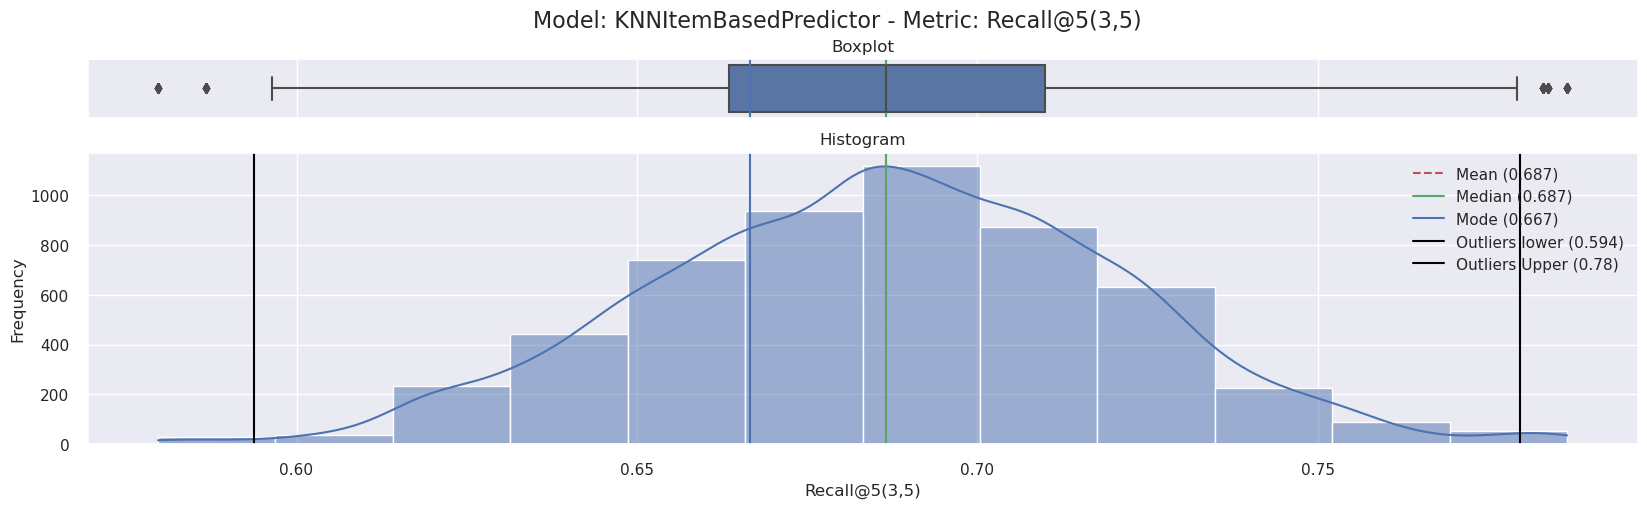

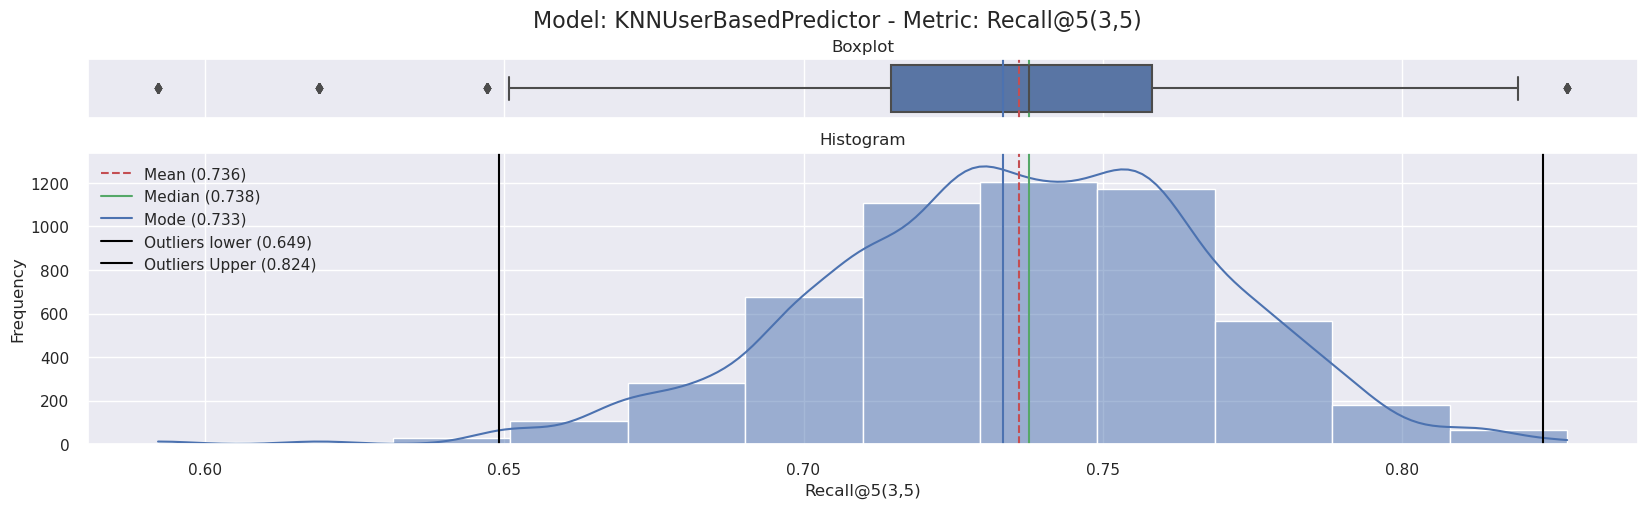

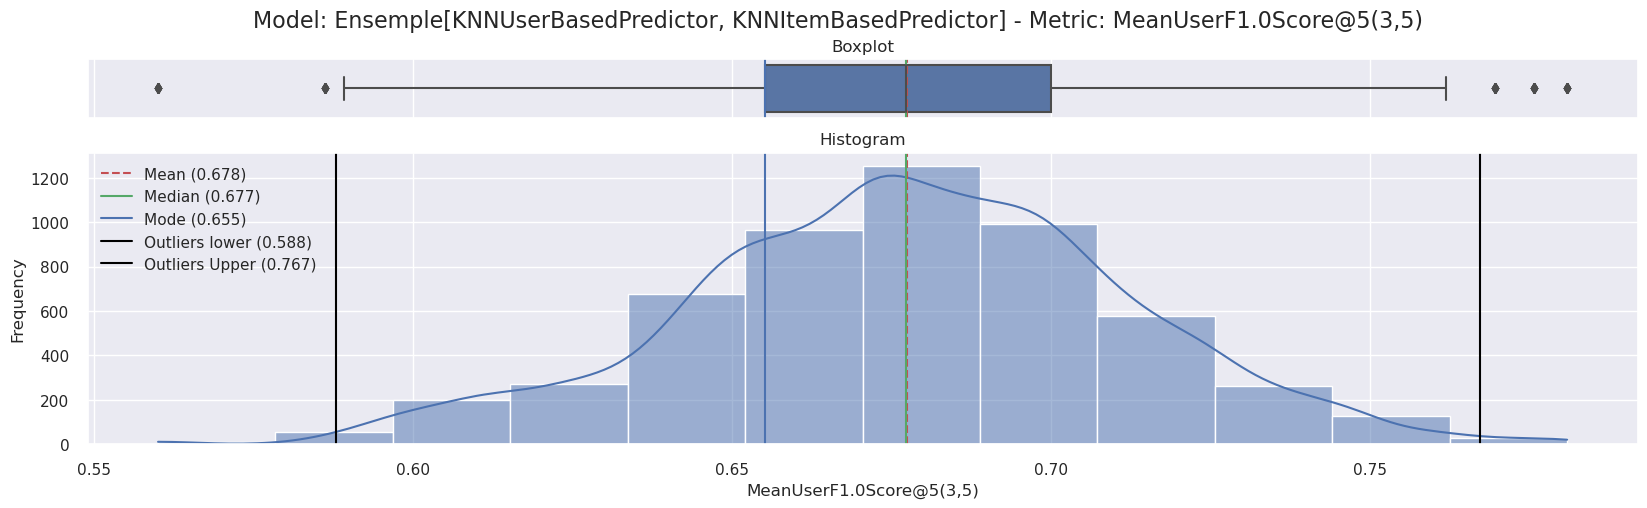

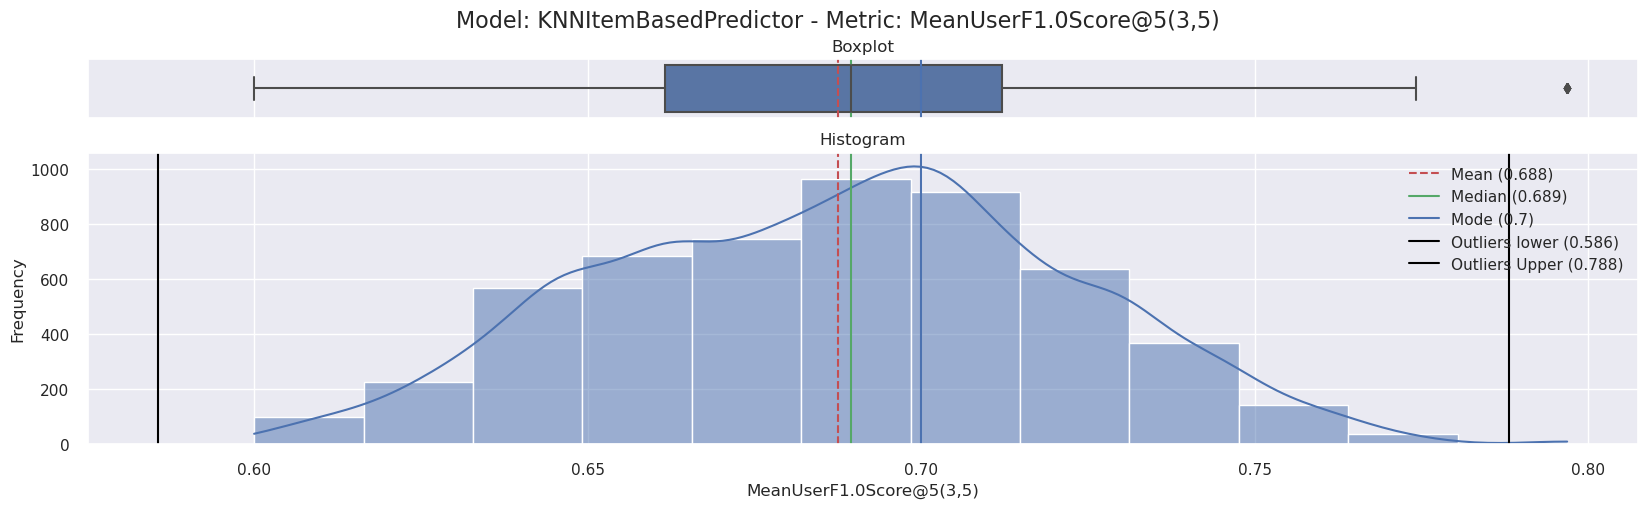

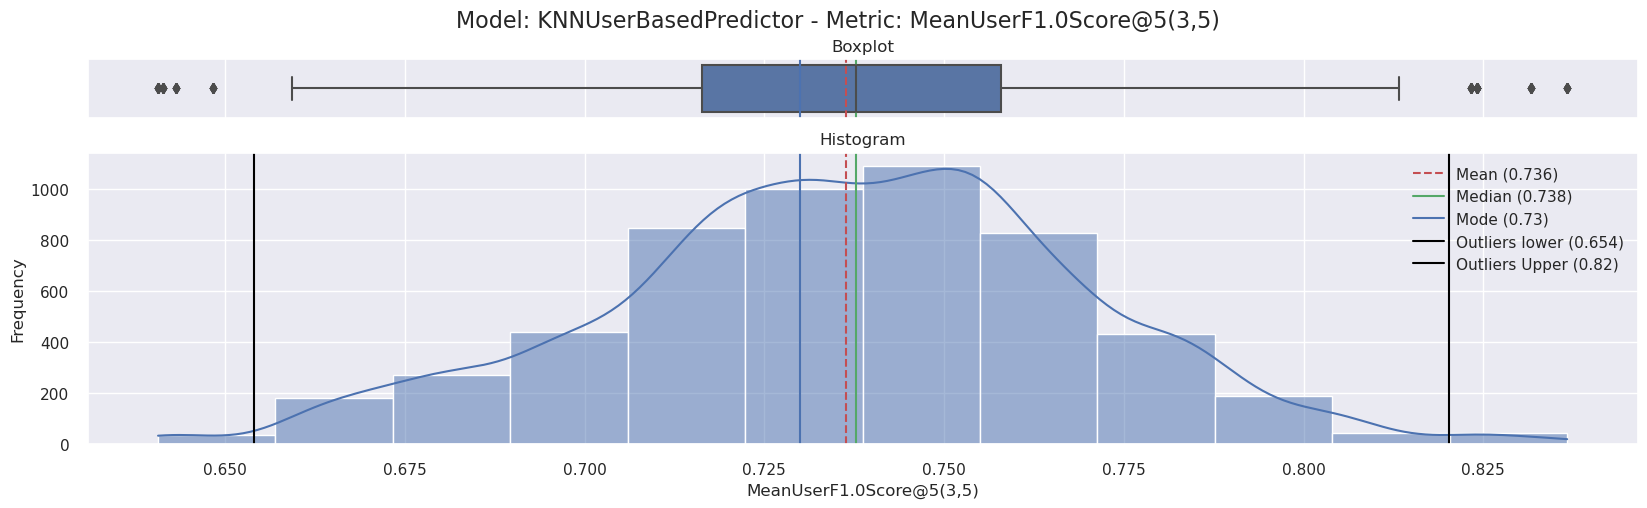

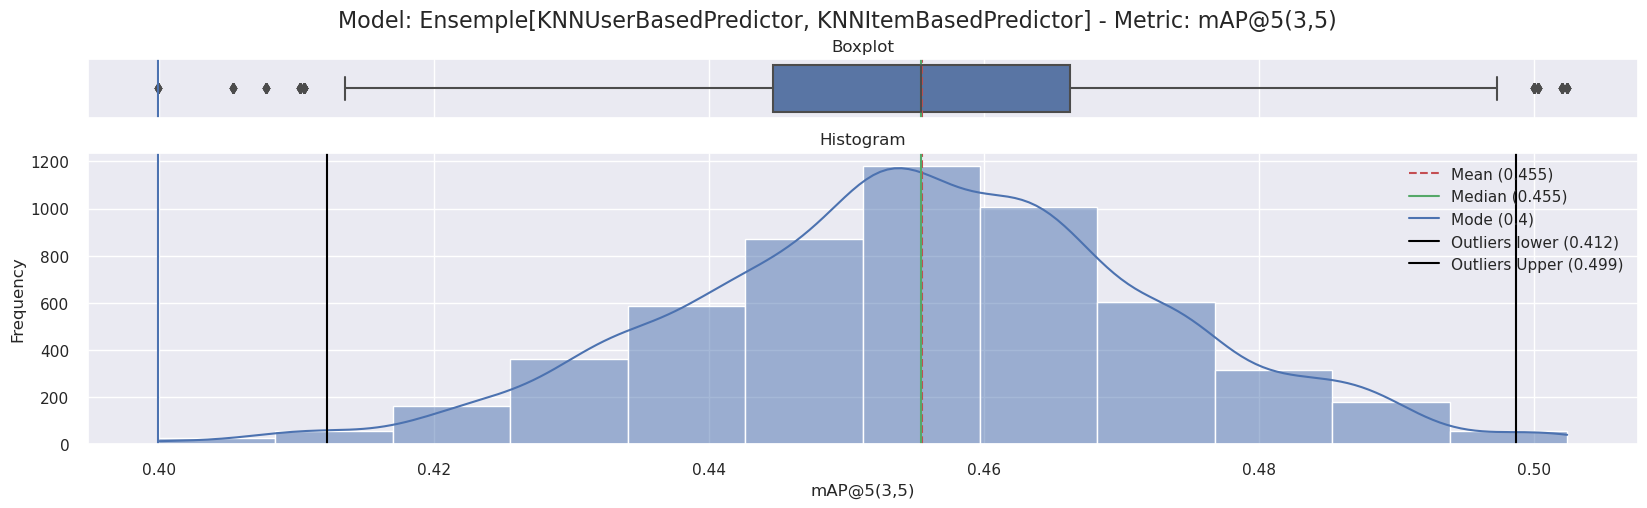

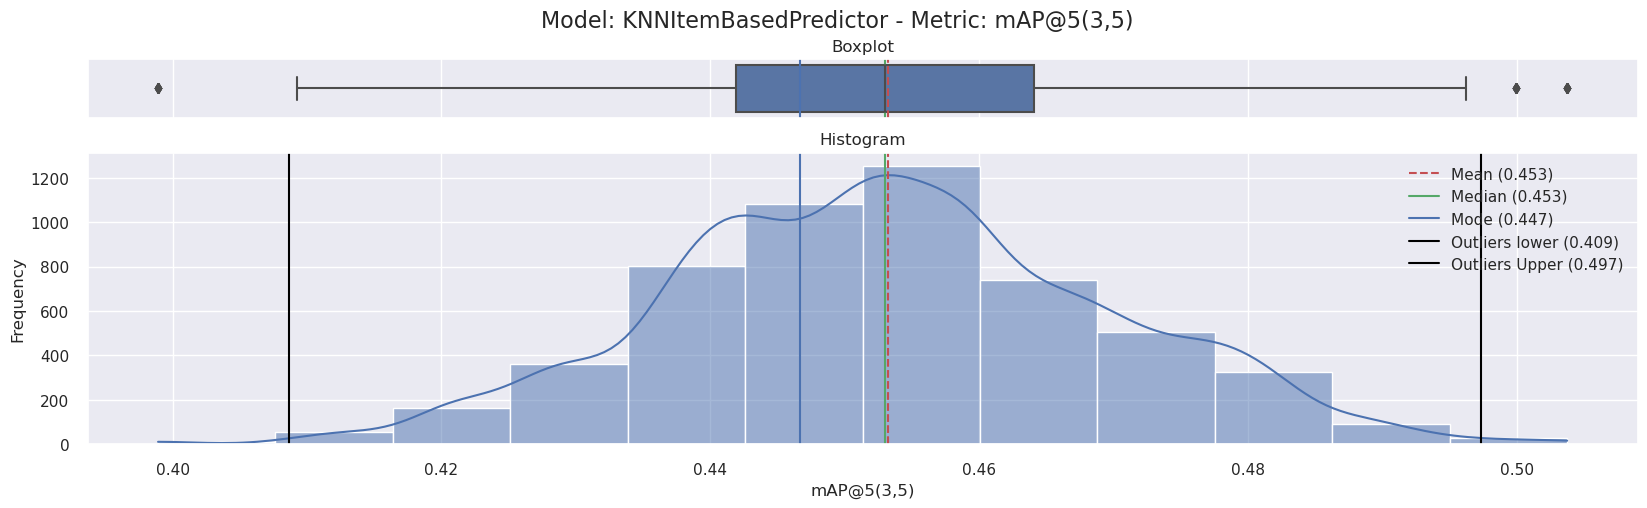

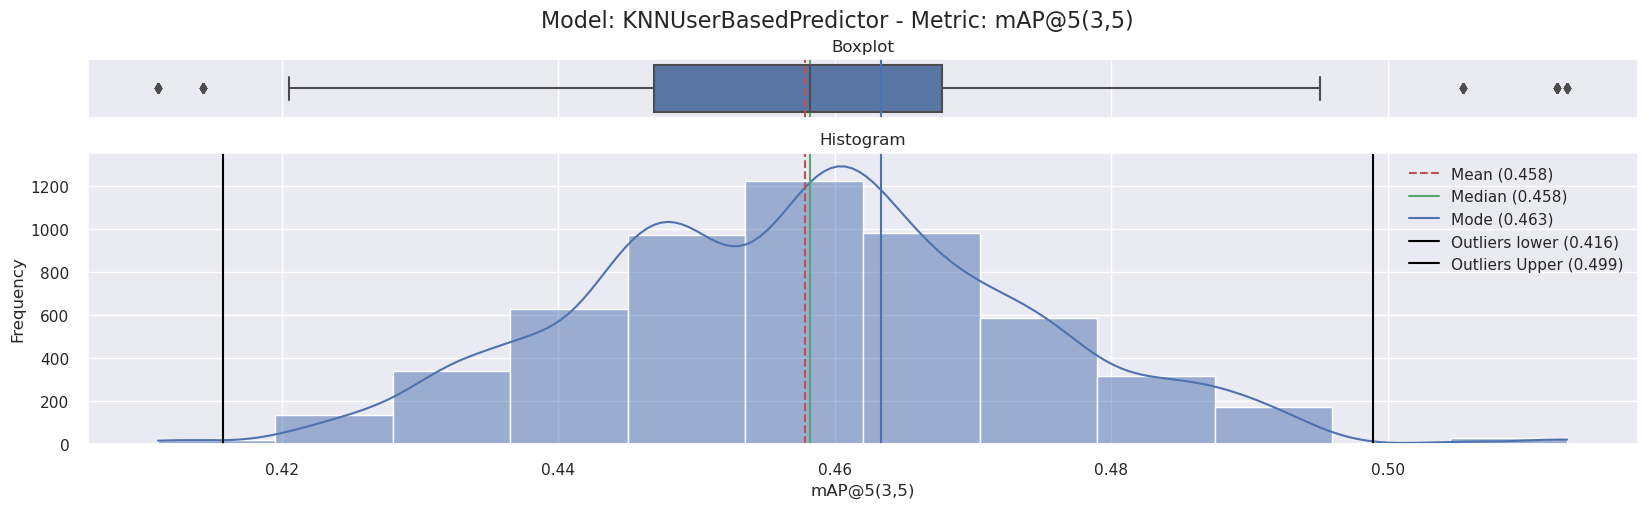

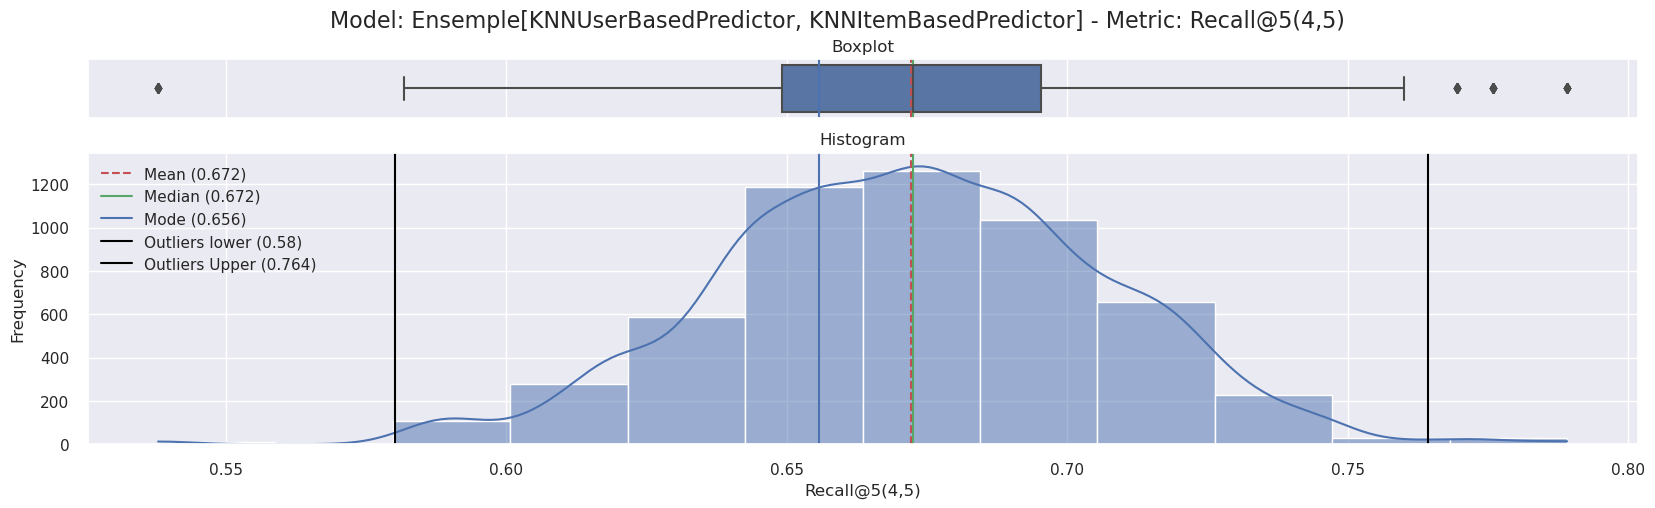

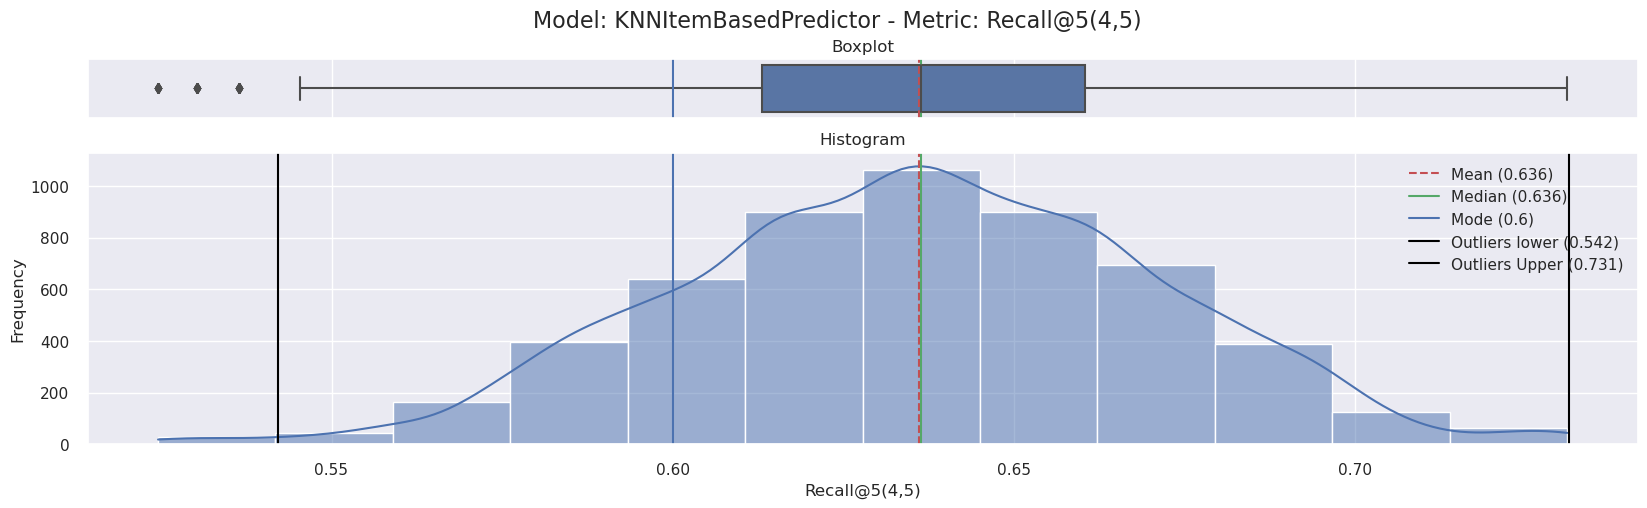

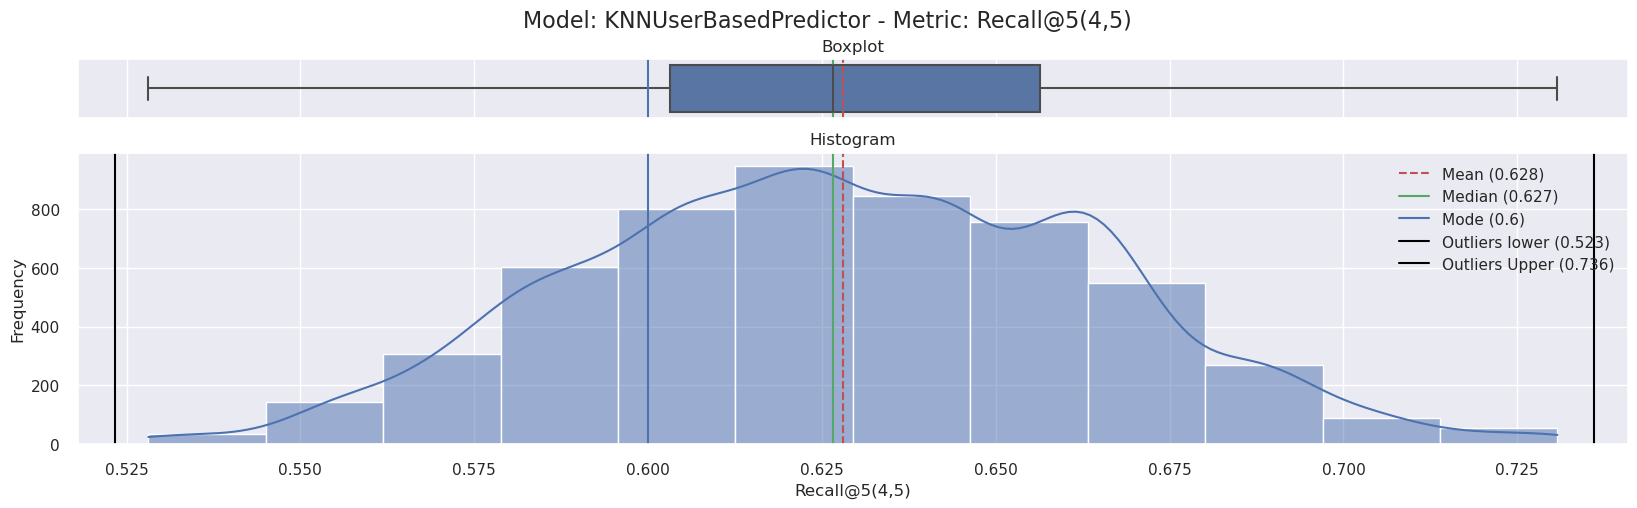

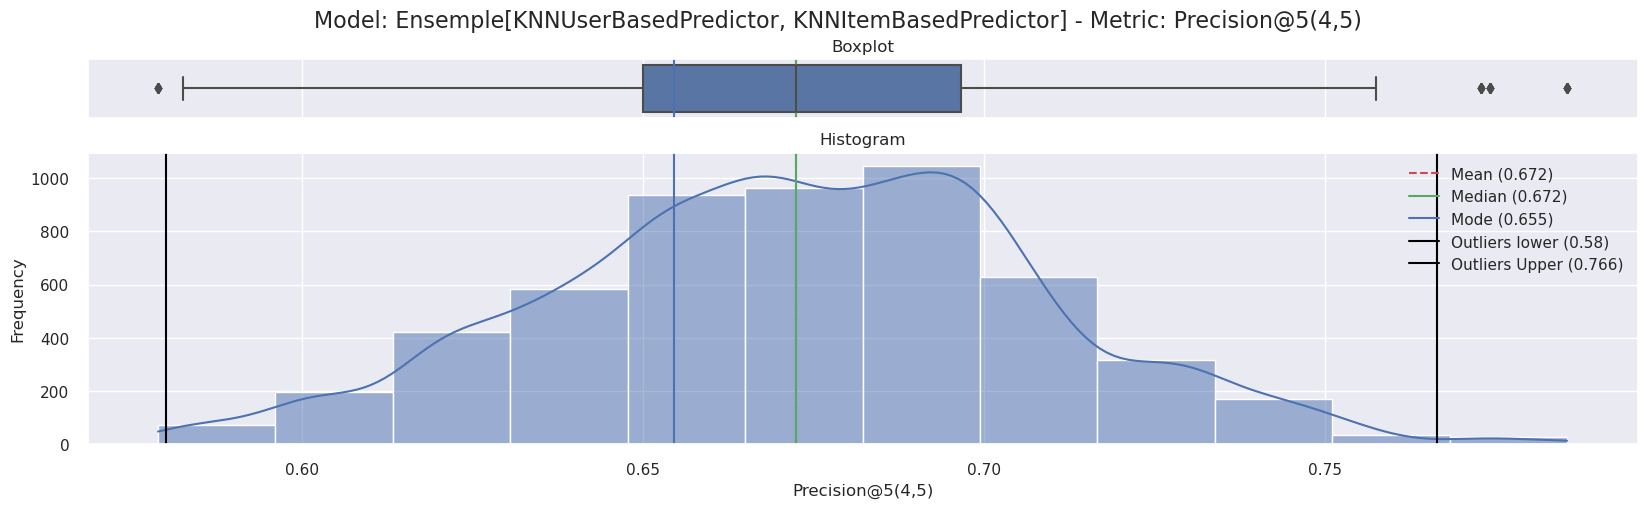

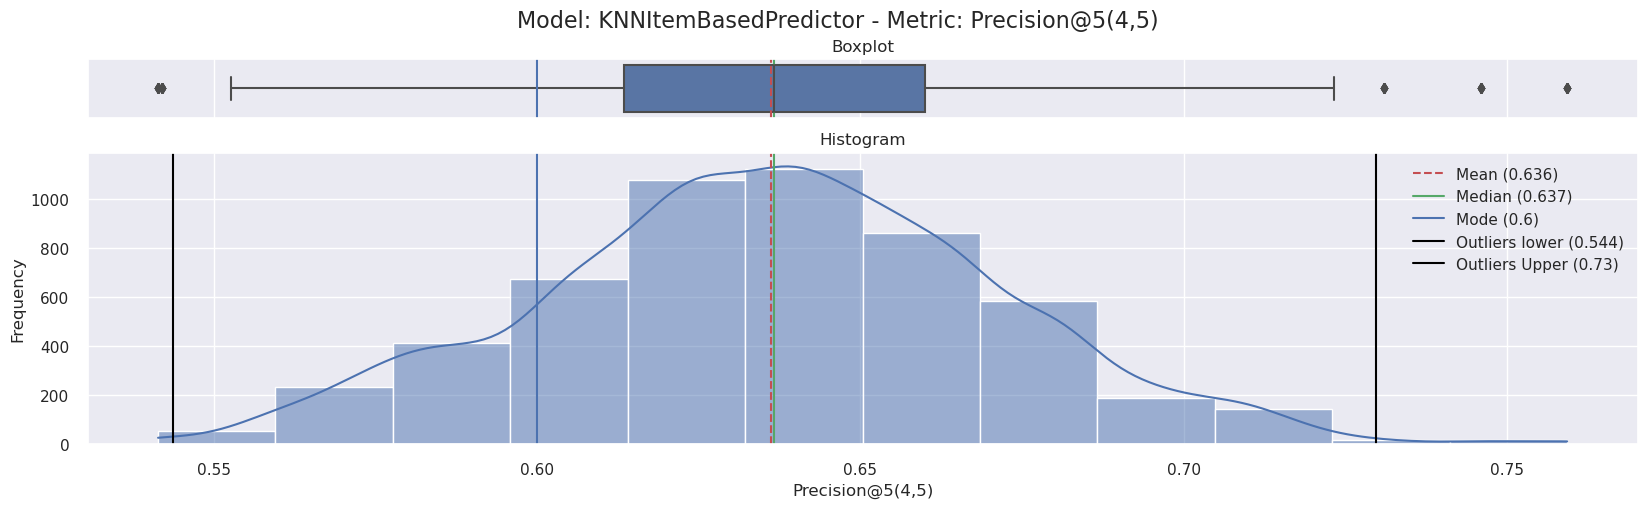

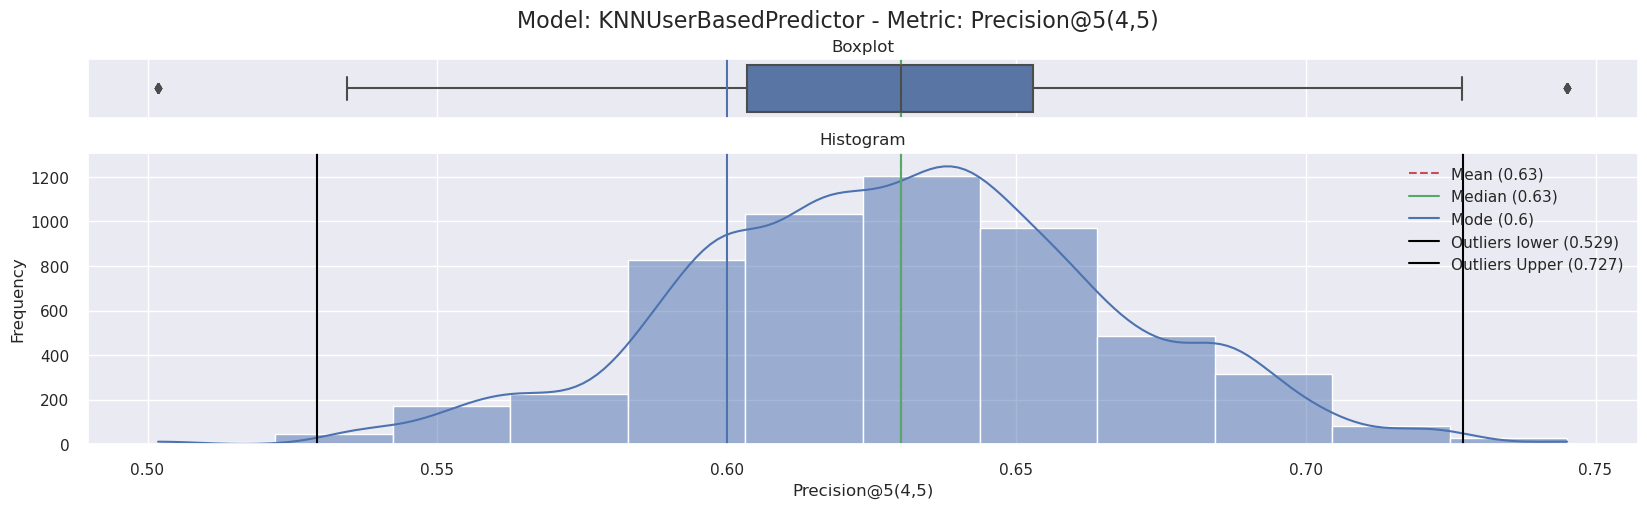

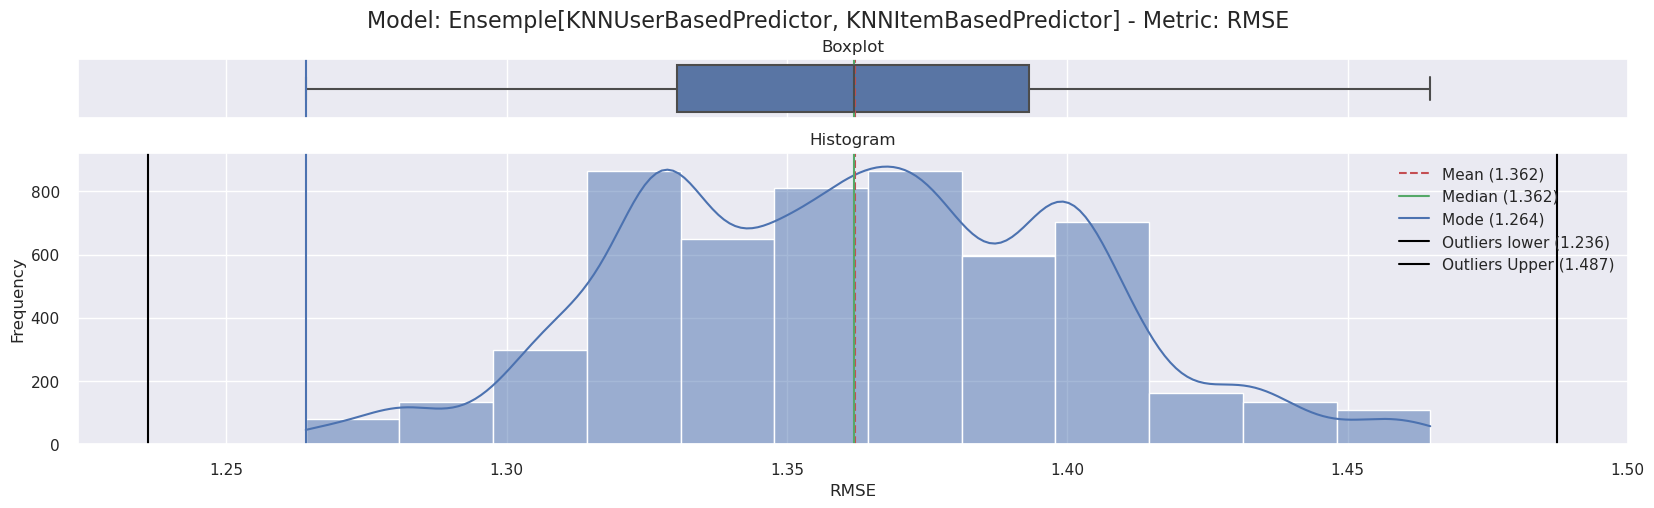

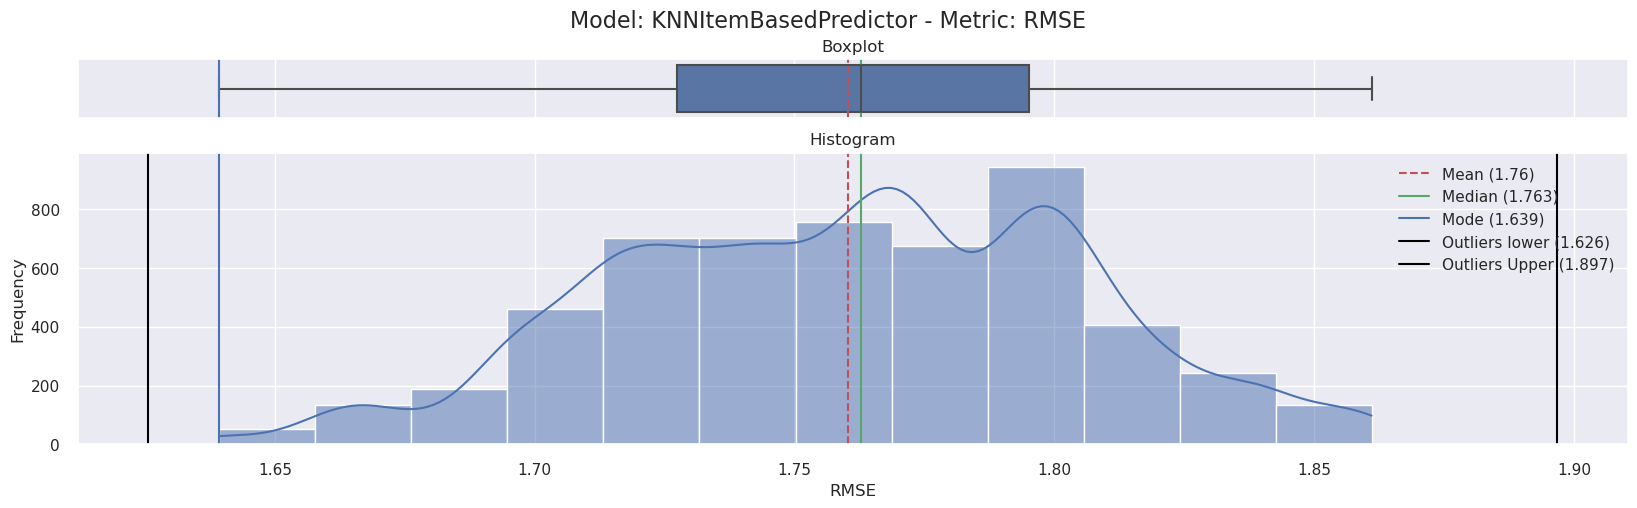

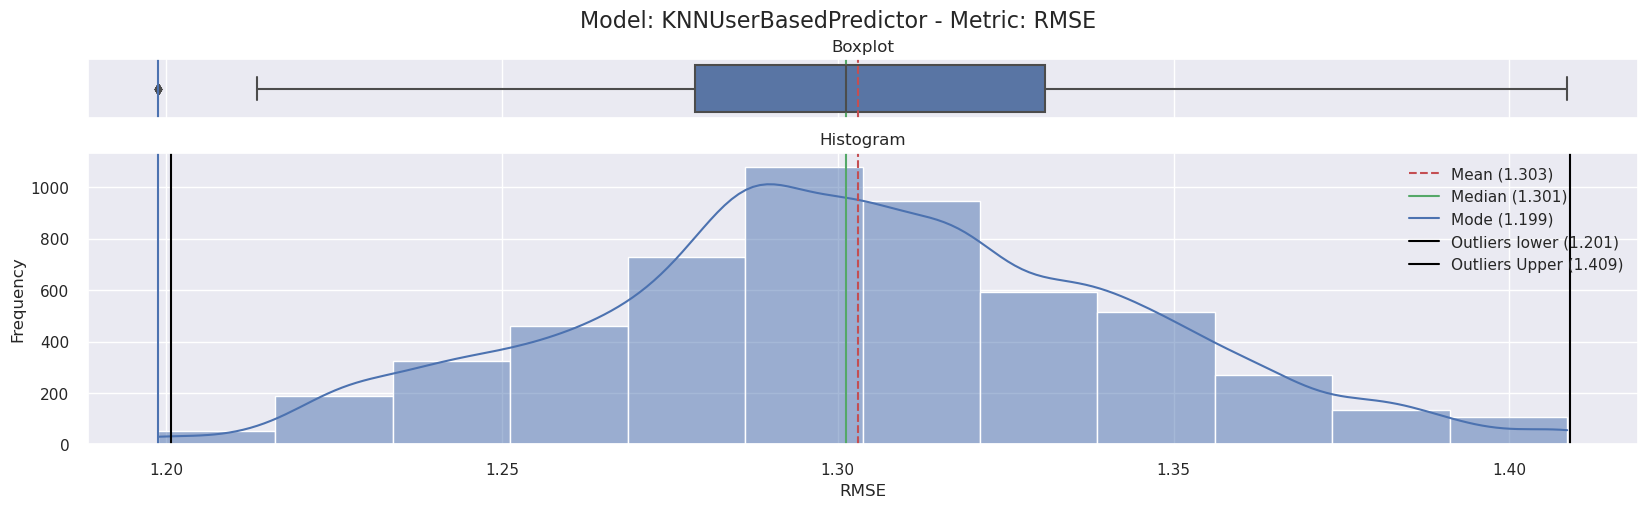

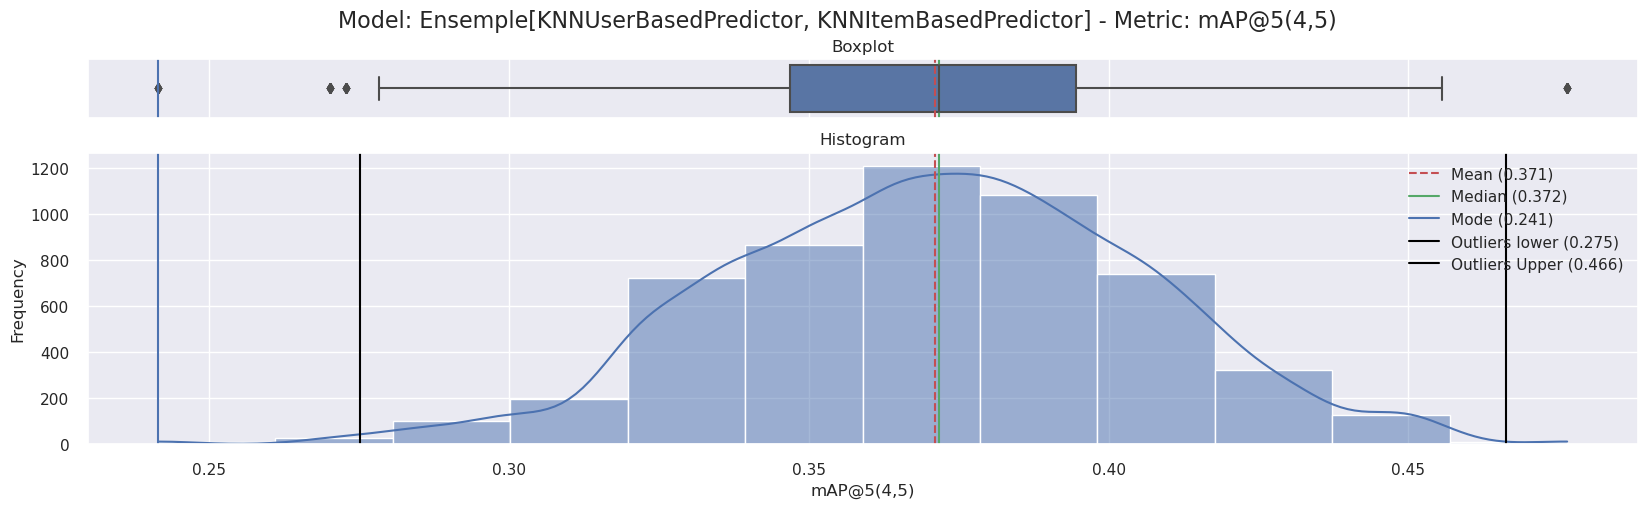

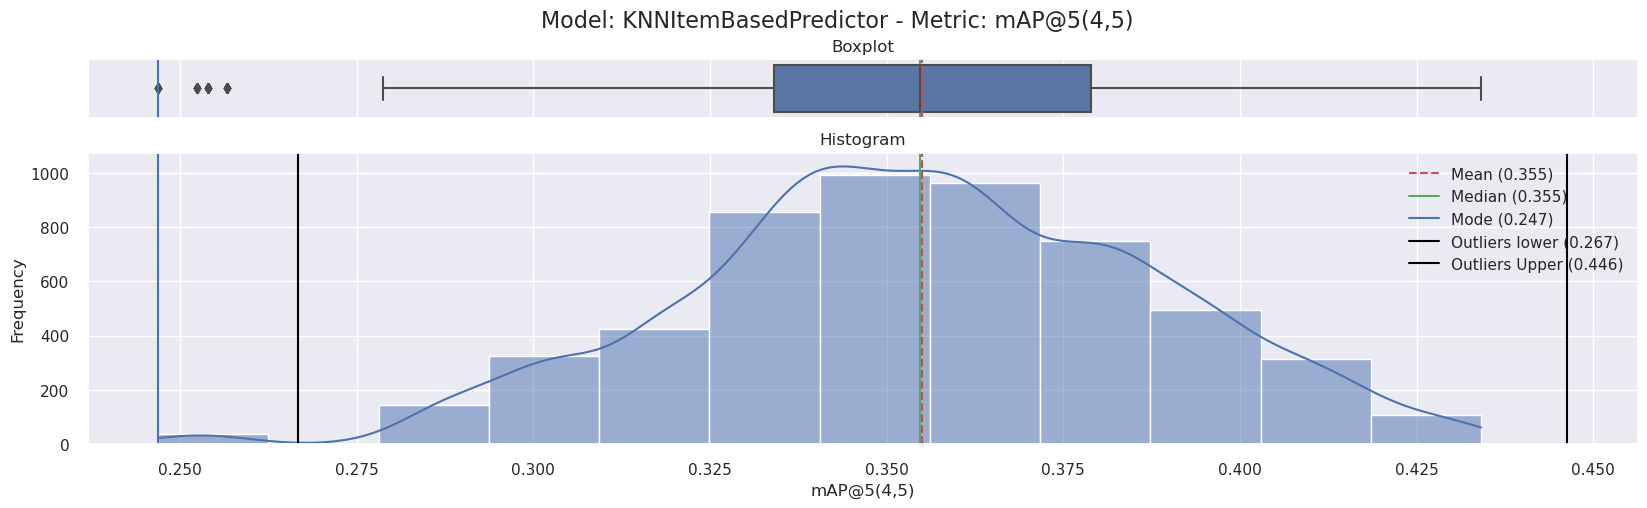

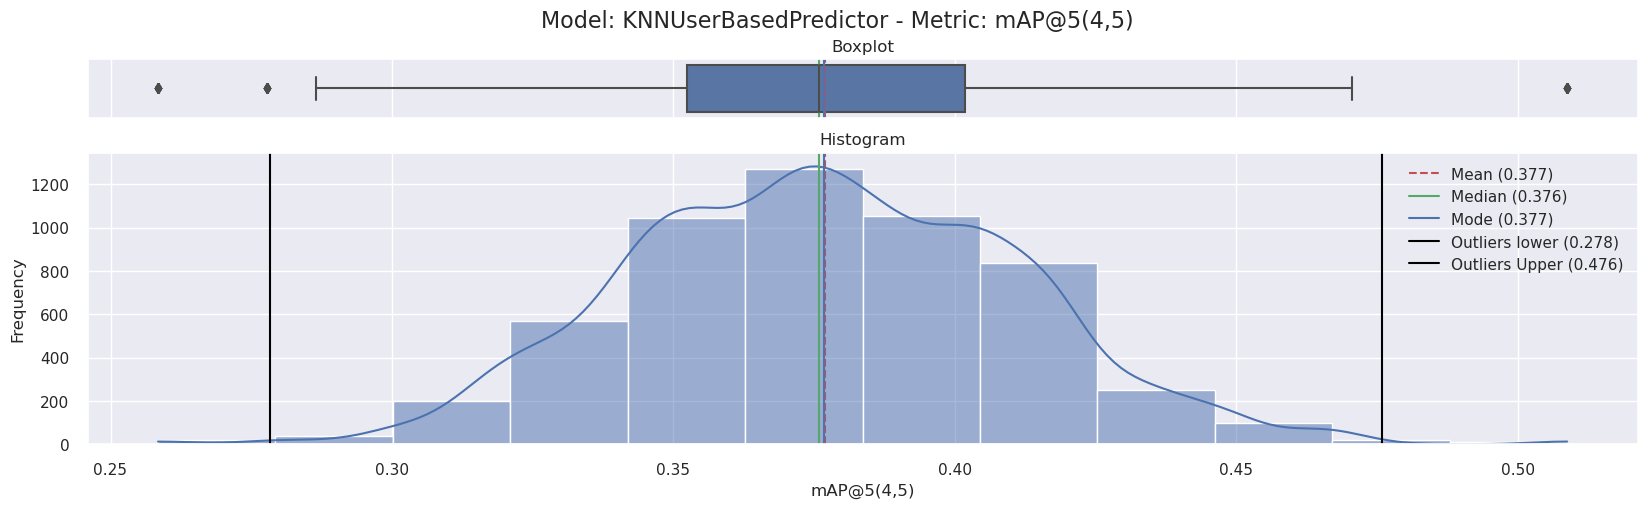

In [33]:
summary.plot(bins=12)